# RynnBrain Inference Recipes

## Section 5: Area Location
In this section, we present the ability for RynnBrain in egocentric area location.

### [Setup] Load visualization utils

In [36]:
import os
ROOT_PATH="" # set the path to root dir
assert ROOT_PATH != "", "Please set ROOT_PATH to the cookbooks directory."
os.chdir(ROOT_PATH)

import glob
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Image as IPyImage
import io
import re
import cv2
import numpy as np
from typing import List, Tuple, Optional

def split_at_middle_space(text, first_line_ratio=0.51):
    text = text.strip()
    space_positions = [i for i, char in enumerate(text) if char == ' ']
    
    if not space_positions:  
        return text
    
    target_pos = int(len(text) * first_line_ratio)
    
    split_pos = min(space_positions, key=lambda x: abs(x - target_pos))
    
    first_line = text[:split_pos].strip()
    second_line = text[split_pos:].strip()
    
    return f"{first_line}\n{second_line}"

def add_frame_id(conversation):
  for message in conversation:
    if message["role"] == "user":
        image_idx = 0
        new_contents = []
        for i, content in enumerate(message["content"]):
            if content["type"] == "image":
                    new_contents.append({"type": "text", "text": f"<frame {image_idx}>: "})
                    image_idx += 1
            new_contents.append(content)
        message["content"] = new_contents
  return conversation


def show_images_grid(
    img_dir,
    n=8,
    cols=4,
    figsize_per_cell=(4, 4),
    exts=("png", "jpg", "jpeg", "bmp", "webp"),
    sort=True,
    show_title=True,
    keep_axis=True,
):
    patterns = [os.path.join(img_dir, f"*.{e}") for e in exts]
    paths = []
    for pat in patterns:
        paths.extend(glob.glob(pat))
    if sort:
        paths = sorted(paths)

    paths = paths[:n]
    if len(paths) == 0:
        raise FileNotFoundError(f"No images found in {img_dir} with extensions {exts}")

    rows = (len(paths) + cols - 1) // cols
    fig_w = figsize_per_cell[0] * cols
    fig_h = figsize_per_cell[1] * rows
    fig, axes = plt.subplots(rows, cols, figsize=(fig_w, fig_h), squeeze=False, dpi=72)

    for i, ax in enumerate(axes.flat):
        if i < len(paths):
            p = paths[i]
            img = Image.open(p)
            ax.imshow(img)

            if show_title:
                ax.set_title(os.path.basename(p), fontsize=10)

            if keep_axis:
                # ax.set_xlabel("x (px)")
                # ax.set_ylabel("y (px)")
                ax.tick_params(labelsize=8)
            else:
                ax.axis("off")
        else:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

def convert_points_to_raw(points_norm, width, height):
    point_list = []
    for point in points_norm:
        x_norm, y_norm = point[0], point[1]
    
        x = round(x_norm / 1000 * width)
        y = round(y_norm / 1000 * height)
        point_list.append((x, y))
    return point_list
  

def parse_frame_id_and_points(output_text: str) -> Tuple[Optional[int], List[Tuple[int, int]]]:
    try:
        frame_match = re.search(r'frame (\d+)', output_text)
        if not frame_match:
            return None, []
        
        frame_id = int(frame_match.group(1))
        
        coord_pattern = r'\((\d+),\s*(\d+)\)'
        coord_matches = re.findall(coord_pattern, output_text)
        
        points = []
        for x_str, y_str in coord_matches:
            try:
                x = int(x_str)
                y = int(y_str)
                points.append((x, y))
            except ValueError:
                continue
        
        return frame_id, points
        
    except Exception as e:
        return None, []

def parse_points(output_text: str) -> Tuple[Optional[int], List[Tuple[int, int]]]:
    try:
        coord_pattern = r'\((\d+),\s*(\d+)\)'
        coord_matches = re.findall(coord_pattern, output_text)
        
        points = []
        for x_str, y_str in coord_matches:
            try:
                x = int(x_str)
                y = int(y_str)
                points.append((x, y))
            except ValueError:
                continue
        
        return points
        
    except Exception as e:
        return []

def draw_points_on_image(img, points, color="red", point_radius=6, width=4, show_width=400, text=None):
    # img = Image.open(img_path).convert("RGB")
    w, h = img.size
    draw = ImageDraw.Draw(img)

    for point in points:
        x, y = point
        draw.ellipse([x-point_radius, y-point_radius, x+point_radius, y+point_radius], 
                    outline=color, width=width, fill=color)
    
    if text:
        if isinstance(text, list):
            text = "\n".join(text)
        text = split_at_middle_space(text)
        
        if points:
            xs = [p[0] for p in points]
            ys = [p[1] for p in points]
            min_x, max_x = min(xs), max(xs)
            min_y, max_y = min(ys), max(ys)
            
            points_bbox_width_shift = 0.1*w
            points_bbox_width = max_x - min_x + points_bbox_width_shift 
            text_length = len(text)
            min_fontsize = 10
            max_fontsize = 40
            
            if points_bbox_width > 0:
                fontsize = max(min_fontsize, min(max_fontsize, int(points_bbox_width / max(1, text_length * 0.07))))
            else:
                fontsize = 12  
        else:
            min_x, min_y = 10, 10  
            fontsize = 12
        # print(fontsize, text_length, points_bbox_width)
        font = ImageFont.truetype("assets/arial.ttf", fontsize)
        
        try:
            bbox_text = draw.textbbox((0, 0), text, font)
        except:
            bbox_text = draw.textsize(text, font)
            bbox_text = (0, 0, bbox_text[0], bbox_text[1])
        
        text_width = bbox_text[2] - bbox_text[0]
        text_height = bbox_text[3] - bbox_text[1]
        
        padding = 10
        text_x = max(min(max_x + 3 * padding, w - text_width - padding), padding)
        text_y = max(min(min_y - text_height - padding, h - text_height - padding), padding)
        
        if text_y < padding:
            text_y = min(max_y + padding, h - text_height - padding)
        
        background_rect = [
            text_x - padding, text_y - padding,
            text_x + text_width + padding, text_y + text_height + 3 * padding
        ]
        draw.rectangle(background_rect, fill=color)
        
        draw.text((text_x, text_y), text, fill="white", font=font)
    
    buf = io.BytesIO()
    img.save(buf, format="PNG")
    buf.seek(0)
    display(IPyImage(data=buf.getvalue(), width=show_width))


### [General] Load Model and Processor

In [2]:
from transformers import AutoModelForImageTextToText, AutoProcessor

model_path = "Alibaba-DAMO-Academy/RynnBrain-8B"
model = AutoModelForImageTextToText.from_pretrained(model_path, dtype="auto", device_map="auto")
processor = AutoProcessor.from_pretrained(model_path)


/usr/local/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 4/4 [16:18<00:00, 244.57s/it]


### Video Example:

1.Load and visualize the video

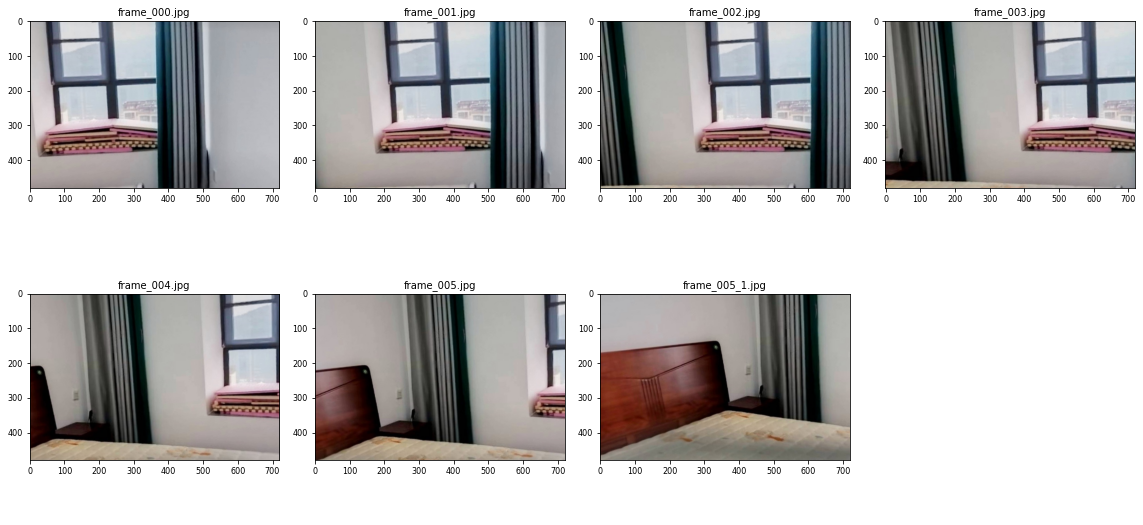

In [37]:
VIDEO_PATH="assets/area_location/videos/0"
show_images_grid(VIDEO_PATH)

2.Generate messages

In [21]:
from pathlib import Path
exts = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

img_paths = sorted(
    [os.path.join(VIDEO_PATH, f) for f in os.listdir(VIDEO_PATH)
     if os.path.splitext(f)[1].lower() in exts]
)
content = []
for p in img_paths:
    content.append({"type": "image", "image": str(p)})

instruction = "Find several locations on the vacant section of the dark brown nightstand beside the bed."
format_prompt = "Two-stage process:\n1. Key frame prediction\n2. Tuple series output.\nOutput format: <area> <frame n>: ...; (x1, y1), (x2, y2), .... </area>\nFormat constraints:\n- Tuple syntax: (x, y)\n- Coordinate bounds: 0 ≤ x,y ≤ 1000\n- Series format: comma-separated."
content.append({"type": "text", "text": f"{instruction}\n{format_prompt}"})

messages = [
    {
        "role": "user",
        "content": content
    }
]
messages = add_frame_id(messages)
print(messages)

[{'role': 'user', 'content': [{'type': 'text', 'text': '<frame 0>: '}, {'type': 'image', 'image': 'assets/area_location/videos/0/frame_000.jpg'}, {'type': 'text', 'text': '<frame 1>: '}, {'type': 'image', 'image': 'assets/area_location/videos/0/frame_001.jpg'}, {'type': 'text', 'text': '<frame 2>: '}, {'type': 'image', 'image': 'assets/area_location/videos/0/frame_002.jpg'}, {'type': 'text', 'text': '<frame 3>: '}, {'type': 'image', 'image': 'assets/area_location/videos/0/frame_003.jpg'}, {'type': 'text', 'text': '<frame 4>: '}, {'type': 'image', 'image': 'assets/area_location/videos/0/frame_004.jpg'}, {'type': 'text', 'text': '<frame 5>: '}, {'type': 'image', 'image': 'assets/area_location/videos/0/frame_005.jpg'}, {'type': 'text', 'text': '<frame 6>: '}, {'type': 'image', 'image': 'assets/area_location/videos/0/frame_005_1.jpg'}, {'type': 'text', 'text': 'Find several locations on the vacant section of the dark brown nightstand beside the bed.\nTwo-stage process:\n1. Key frame predic

3.Infer with RynnBrain

In [22]:
inputs = processor.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    return_dict=True,
    return_tensors="pt"
)
inputs = inputs.to(model.device)

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)[0]
print(output_text)

The area is at <area> <frame 5>: ; (328, 812), (308, 817), (314, 817), (316, 818), (323, 814) </area>


4.Visualization

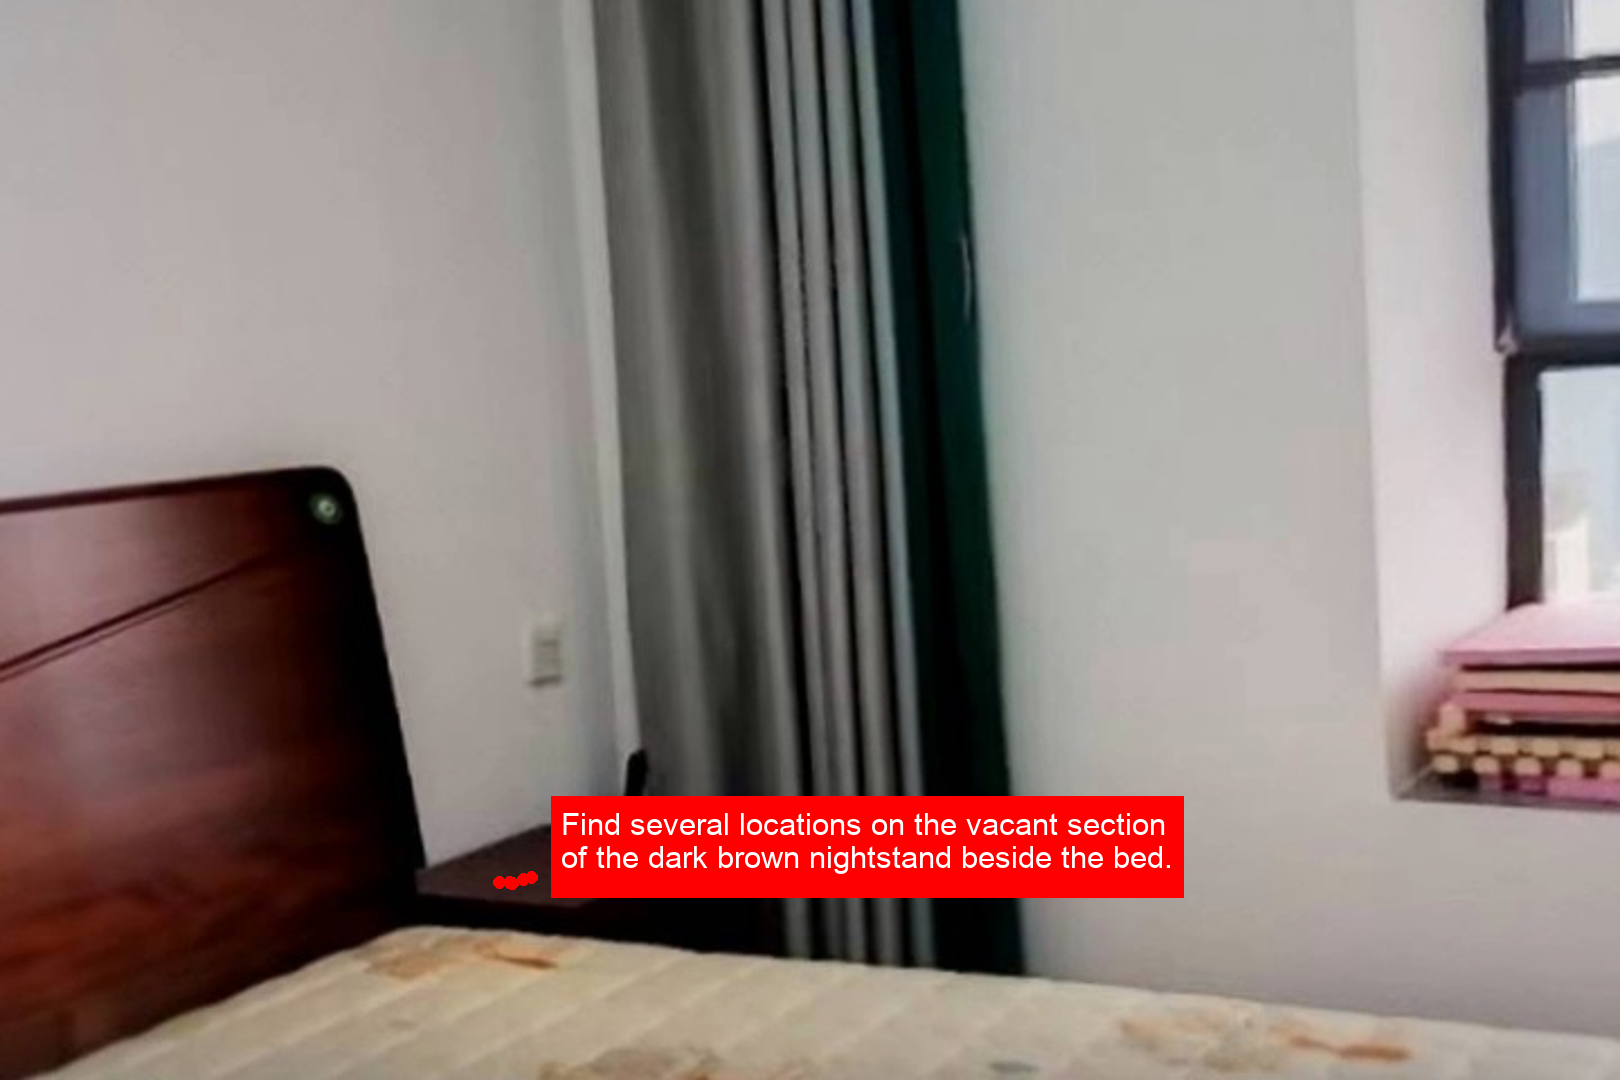

In [23]:
frame_id, points = parse_frame_id_and_points(output_text)
img_path = img_paths[frame_id]
img = Image.open(img_path).convert("RGB")
img = img.resize((int(1080*img.size[0]/img.size[1]),1080))
w, h = img.size
points_raw = convert_points_to_raw(points, w, h)
# print(frame_id, points, w, h, points_raw)
draw_points_on_image(img, points_raw, color="red", point_radius=6, width=4, show_width=600, text=instruction)

### Image Example:

1.Generate messages

In [34]:
from pathlib import Path
exts = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

image_path = "assets/area_location/images/Snipaste_2025-03-06_11-04-32.jpg"
content = []
content.append({"type": "image", "image": image_path})

instruction = "Find several locations within the clear area to the right of the black mesh organizer."
format_prompt = "Express the coordinates as a tuple sequence in the format <area> (x1, y1), (x2, y2), ... </area> with all coordinate values normalized to the standardized pixel coordinate system spanning 0 to 1000."
content.append({"type": "text", "text": f"{instruction}\n{format_prompt}"})

messages = [
    {
        "role": "user",
        "content": content
    }
]
# messages = add_frame_id(messages)
print(messages)

[{'role': 'user', 'content': [{'type': 'image', 'image': 'assets/area_location/images/Snipaste_2025-03-06_11-04-32.jpg'}, {'type': 'text', 'text': 'Find several locations within the clear area to the right of the black mesh organizer.\nExpress the coordinates as a tuple sequence in the format <area> (x1, y1), (x2, y2), ... </area> with all coordinate values normalized to the standardized pixel coordinate system spanning 0 to 1000.'}]}]


2.Infer with RynnBrain 

In [35]:
inputs = processor.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    return_dict=True,
    return_tensors="pt"
)
inputs = inputs.to(model.device)

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)[0]
print(output_text)

<area> (384, 965), (403, 952), (413, 984), (392, 992), (394, 997) </area>


3.Visualization

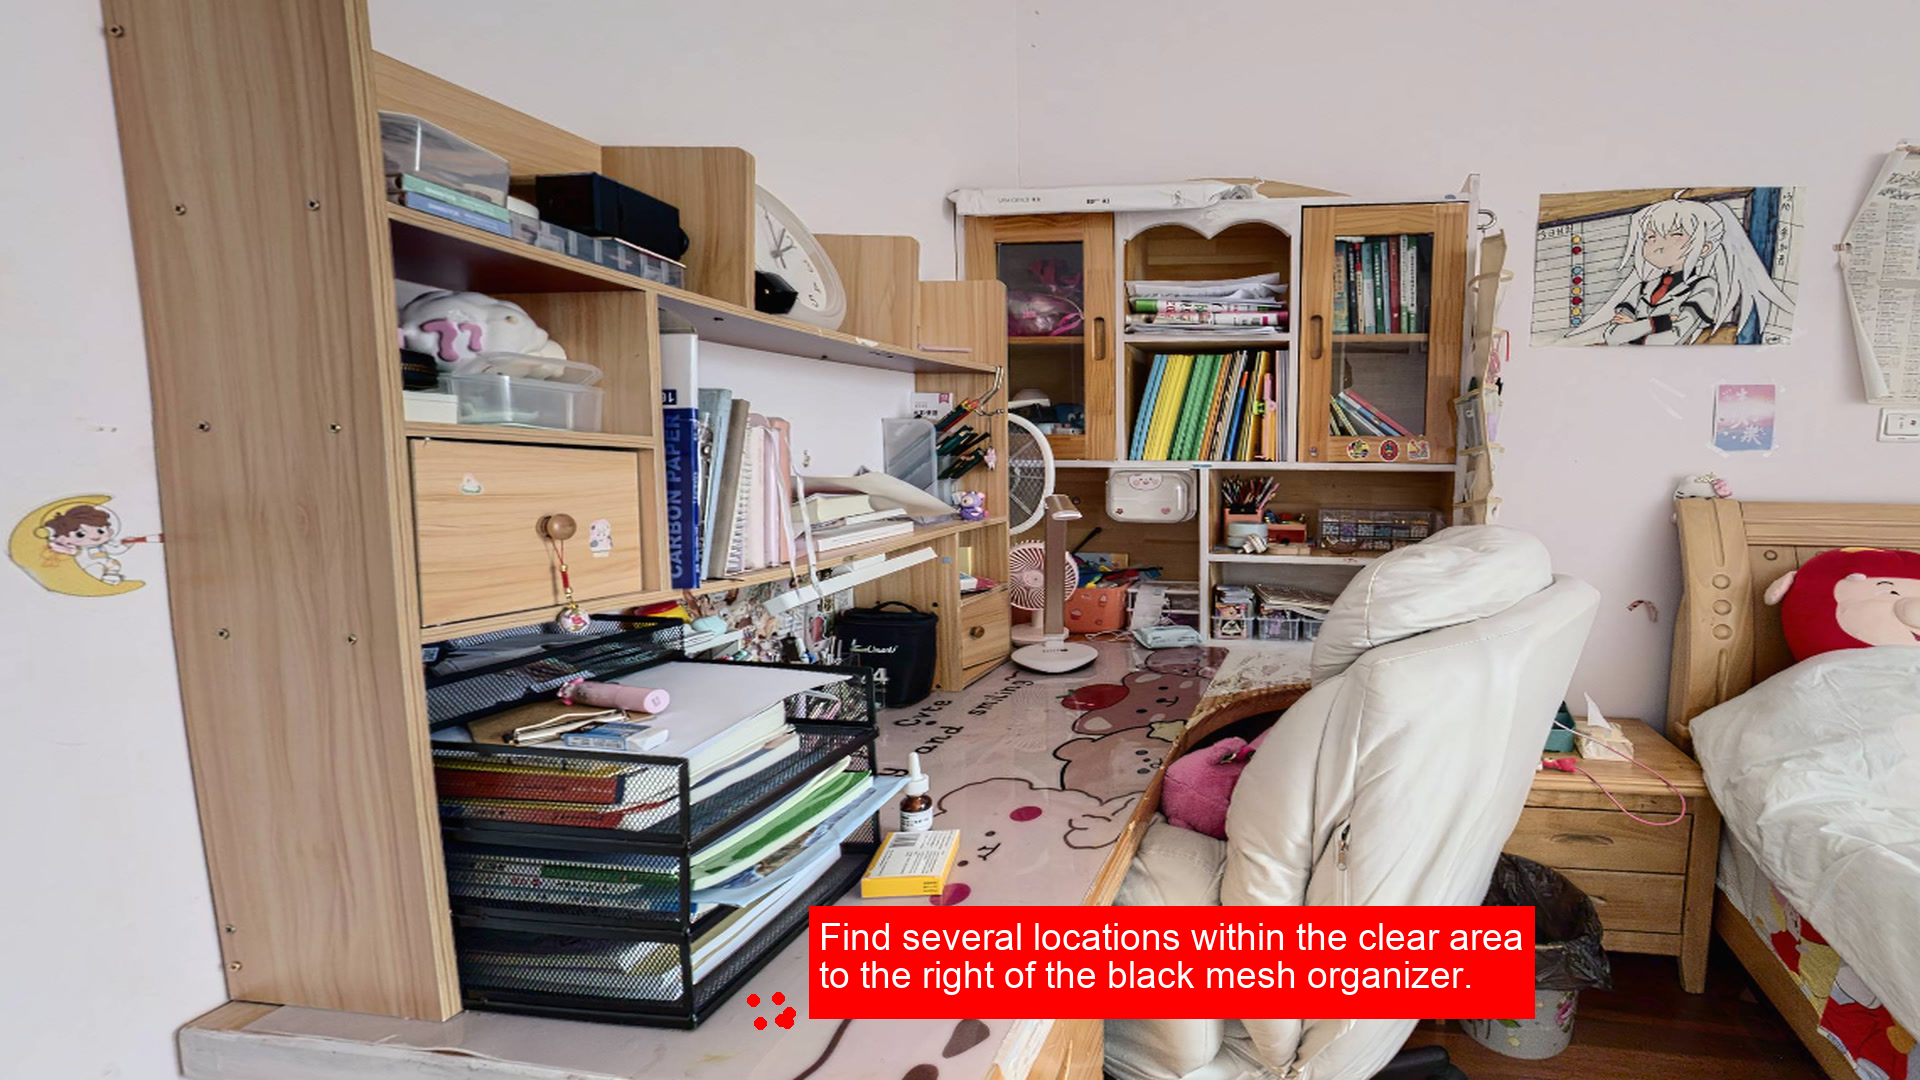

In [33]:
points = parse_points(output_text)
image = Image.open(image_path).convert("RGB")
image = image.resize((int(1080*image.size[0]/image.size[1]),1080))
w, h = image.size
points_raw = convert_points_to_raw(points, w, h)
# print(frame_id, points, w, h, points_raw)
draw_points_on_image(image, points_raw, color="red", point_radius=6, width=4, show_width=600, text=instruction)